<a href="https://colab.research.google.com/github/arsxlanali/aws_machine_learning/blob/master/FinancialSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import numpy as np
import string
import re

In [2]:
dataframe = pd.read_csv('./data.csv')

In [3]:
dataframe

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


In [4]:
# Define the regular expression pattern
pattern = r"(#\w+)|(@\w+)|(https?://\S+)"

translator = str.maketrans('', '', string.punctuation)
# Apply the regular expression to the 'tweet' column
dataframe['Sentence'] = dataframe['Sentence'].apply(lambda x: 
                                                re.sub(pattern, "", x)
                                                .translate(translator))

In [5]:
dataframe

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,ESI on lows down 150 to 250 BK a real possibility,negative
2,For the last quarter of 2010 Componenta s net...,positive
3,According to the FinnishRussian Chamber of Com...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,According shipping company Viking Line the EU...,neutral
5840,In the building and home improvement trade sa...,neutral


In [6]:
dataframe['Sentiment'].replace(to_replace= 'positive', value = 0, inplace=True )
dataframe['Sentiment'].replace(to_replace= 'neutral', value = 1, inplace=True )
dataframe['Sentiment'].replace(to_replace= 'negative', value = 2, inplace=True )
text_data = list(dataframe['Sentence'])
labels = list(dataframe['Sentiment'])
labels = np.array(labels)

In [7]:
labels

array([0, 2, 0, ..., 1, 1, 0])

In [8]:
#Tokenize the text data and create the feature vectors
#we will use a simple bag-of-words representation
vocab = set([word for text in text_data for word in text.split()])
feature_vectors = []
for text in text_data:
    feature_vector = [1 if word in text.split() else 0 for word in vocab]
    feature_vectors.append(feature_vector)

In [9]:
# Pad the sequences to the same length
max_length = max([len(doc) for doc in feature_vectors])
padded_sequences = pad_sequences(feature_vectors, maxlen=max_length, padding='post', truncating='post')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [11]:
X_train[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [12]:
# Define the CNN model
model = Sequential()
model.add(Embedding(input_dim=len(vocab), output_dim=300, input_length=max_length))
model.add(Conv1D(filters=100, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14067, 300)        4220100   
                                                                 
 conv1d (Conv1D)             (None, 14065, 100)        90100     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7032, 100)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 703200)            0         
                                                                 
 dense (Dense)               (None, 3)                 2109603   
                                                                 
Total params: 6,419,803
Trainable params: 6,419,803
Non-trainable params: 0
______________________________________________

In [13]:
# Train the model
cnn = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/5
147/147 [==============================] - 27s 161ms/step - loss: 0.9434 - accuracy: 0.6140 - val_loss: 0.7019 - val_accuracy: 0.6963
Epoch 2/5
147/147 [==============================] - 24s 160ms/step - loss: 0.4794 - accuracy: 0.8080 - val_loss: 0.7611 - val_accuracy: 0.6920
Epoch 3/5
147/147 [==============================] - 24s 164ms/step - loss: 0.3098 - accuracy: 0.8735 - val_loss: 0.8950 - val_accuracy: 0.6835
Epoch 4/5
147/147 [==============================] - 23s 157ms/step - loss: 0.2594 - accuracy: 0.8892 - val_loss: 0.9414 - val_accuracy: 0.6792
Epoch 5/5
147/147 [==============================] - 23s 157ms/step - loss: 0.2305 - accuracy: 0.8939 - val_loss: 0.9401 - val_accuracy: 0.6784
Accuracy: 67.84%


## Testing

In [14]:
text = "SPY wouldn't be surprised to see a green close"
feature_vectors = []
feature_vector = [1 if word in text.split() else 0 for word in vocab]
feature_vectors.append(feature_vector)
padded_sequences = pad_sequences(feature_vectors, maxlen=max_length, padding='post', truncating='post')
pred = np.argmax(model.predict(padded_sequences))
if pred==0:
  print('Positive')
elif pred==1:
  print("Neutral")
else:
  print("Negative")

1/1 [==============================] - 0s 78ms/step
Positive


## Evalution

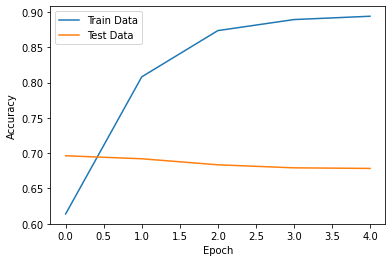

In [15]:
plt.plot(cnn.history['accuracy'], label='Train Data')
plt.plot(cnn.history['val_accuracy'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.8, 1])
plt.legend(loc='best')
plt.show()

In [16]:
predictions = model.predict(X_test)
predictions[0]

37/37 [==============================] - 2s 51ms/step


array([0.03404901, 0.95946145, 0.00648946], dtype=float32)

In [17]:
prediction = np.array([])
for i in predictions:
  prediction = np.append(prediction,np.argmax(i))

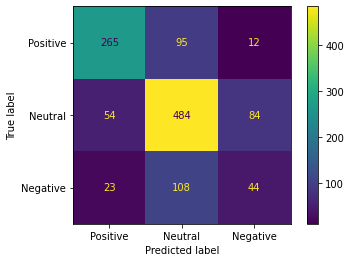

In [18]:
# Calculate the confusion matrix
confusion_matrix = confusion_matrix(y_test, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels =['Positive','Neutral','Negative'])

cm_display.plot()
plt.show()